In [9]:
"""Load combined diffusion-relaxometry data and mask"""

# Access the data 
from os.path import expanduser, join
home = expanduser('~')
dname = join(home, 'brain-data-neil')

fdwi = join(dname, 'cdmri11_r.nii') # nifti file with whole-brain MRI data
mask = join(dname, 'vol0083_brain_mask.nii.gz') # brain mask
fbval = join(dname, 'parameters_new_bval.txt') # list of b-values
fbvec = join(dname, 'parameters_new_bvec2.txt') # list of b-vectors

# Load dMRI datasets using Dipy
from dipy.io.image import load_nifti
data, affine, img = load_nifti(fdwi, return_img=True)
mask_data, affine1, img1 = load_nifti(mask, return_img=True)

# Check size of data --> (77, 92, 56, 1344)
print(data.shape)

(77, 92, 56, 1344)


In [11]:
"""Set up acquisition scheme using b-values, b-vectors, TI, TE"""

# Import relevant modules
from os.path import join
import numpy as np
from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues

# Load parameters and convert to SI units
bvalues = np.loadtxt(join('parameters_new_bval.txt'))  # given in s/m^2
bvalues_SI = bvalues * 1e6 # now given in SI units as s/mm^2
gradient_directions = np.loadtxt(join('parameters_new_bvec.txt'))
delta = 0.0242 # time in seconds
Delta = 0.0391 # time in seconds
grad_echo_inv = np.loadtxt(join('parameters_new.txt'))
TE = grad_echo_inv[:,5]/1e3
TI = grad_echo_inv[:,4]/1e3

# Acquisition scheme
acq_scheme = acquisition_scheme_from_bvalues(bvalues_SI, gradient_directions, delta, Delta, TE, TI)
acq_scheme.print_acquisition_info

Acquisition scheme summary

total number of measurements: 1344
number of b0 measurements: 84
number of DWI shells: 12

shell_index |# of DWIs |bvalue [s/mm^2] |gradient strength [mT/m] |delta [ms] |Delta[ms] |TE[ms] |TI[ms]
0           |28        |0               |0                        |24.2       |39.1      |80.0 	|1059.7
1           |28        |500             |19                       |24.2       |39.1      |80.0 	|883.12
2           |84        |1000            |27                       |24.2       |39.1      |80.0 	|176.62
3           |140       |2000            |39                       |24.2       |39.1      |80.0 	|529.87
4           |168       |3000            |48                       |24.2       |39.1      |80.0 	|20.0 
5           |28        |0               |0                        |24.2       |39.1      |105.0	|1059.7
6           |28        |500             |19                       |24.2       |39.1      |105.0	|883.12
7           |84        |1000            |27      

In [13]:
"""Create RELAXED ball & stick model using modified Dmipy code"""

# Import relevant modules
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

# Initiate RELAXED ball and stick model
stick = cylinder_models.C1StickRelaxed()
ball = gaussian_models.G1BallRelaxed()
relaxed_BAS = MultiCompartmentModel(models=[ball, stick])

# Display parameters for model
print(relaxed_BAS.parameter_cardinality)

# Set initial guesses for certain parameters to speed up processing
relaxed_BAS.set_initial_guess_parameter('G1BallRelaxed_1_t2', 0.120) # T2 ball
relaxed_BAS.set_initial_guess_parameter('G1BallRelaxed_1_t1', 3) # T1 ball
relaxed_BAS.set_initial_guess_parameter('C1StickRelaxed_1_t2', 0.080) # T2 stick
relaxed_BAS.set_initial_guess_parameter('C1StickRelaxed_1_t1', 2) # T1 stick
relaxed_BAS.set_initial_guess_parameter('G1BallRelaxed_1_lambda_iso', 1e-09) # Ball diffusivity
relaxed_BAS.set_initial_guess_parameter('C1StickRelaxed_1_lambda_par', 2.2e-09) # Stick axial diffusivity

OrderedDict([('G1BallRelaxed_1_lambda_iso', 1), ('G1BallRelaxed_1_t2', 1), ('G1BallRelaxed_1_t1', 1), ('C1StickRelaxed_1_mu', 2), ('C1StickRelaxed_1_lambda_par', 1), ('C1StickRelaxed_1_t2', 1), ('C1StickRelaxed_1_t1', 1), ('partial_volume_0', 1), ('partial_volume_1', 1)])


In [ ]:
"""Create synthetic combined diffusion-relaxometry dataset"""

# Import numpy to create arrays
import numpy as np
ml_dataset = np.zeros((100000, data.shape[3]))

# Use random values for the parameters from the relaxed ball and stick model
part_vol_zero = np.random.uniform(0,1,100000) # Ball volume fraction
lambda_iso = np.random.uniform(0,3,100000)*1e-9 # Ball diffusivity
stick_t2 = np.random.uniform(20,400,100000)*1e-3 # T2 stick
ball_t2 = np.random.uniform(20,400,100000)*1e-3 # T2 ball
stick_t1 = np.random.uniform(0,4000,100000)*1e-3 # T1 stick
ball_t1 = np.random.uniform(0,4000,100000)*1e-3 # T1 ball
cos_theta = np.random.uniform(-1,1,100000)
phi = np.random.uniform(-np.pi,np.pi,100000)
mu = np.zeros((2,10**5)) # Stick fibre direction
mu[0,] = np.arccos(cos_theta)
mu[1,] = phi
lambda_par = np.random.uniform(0,3,100000)*1e-9 # Stick axial diffusivity

param_dataset = np.zeros((100000, 10))

for n in range(100000):
    print(lambda_iso)
    param_vector = relaxed_BAS.parameters_to_parameter_vector(
        G1BallRelaxed_1_lambda_iso=lambda_iso[n], 
        G1BallRelaxed_1_t2=ball_t2[n], 
        G1BallRelaxed_1_t1=ball_t1[n], 
        C1StickRelaxed_1_mu=mu[:,n], 
        C1StickRelaxed_1_lambda_par=lambda_par[n],
        C1StickRelaxed_1_t2=stick_t2[n], 
        C1StickRelaxed_1_t1=stick_t1[n],
        partial_volume_0=part_vol_zero[n], 
        partial_volume_1=1-part_vol_zero[n])
    ml_dataset[n,] = relaxed_BAS.simulate_signal(acq_scheme, param_vector)
    param_dataset[n,] = param_vector

In [15]:
# Check the size of the synthetic dataset
print(mu.shape)
print(ml_dataset.shape)
print(param_dataset.shape)

(2, 100000)
(100000, 1344)
(100000, 10)


In [18]:
# Standard Python libraries for data and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import train_test_split to split data into training & test sets
from sklearn.model_selection import train_test_split

# Display charts in the notebook
%matplotlib inline

In [19]:
"""Split data into training (80%) & testing (20%) for the original dataset"""

X_train, X_test, y_train, y_test = train_test_split(ml_dataset, param_dataset, test_size=0.2, random_state=42)

In [21]:
"""Initiate scikit-learn's Random Forest regressor with 200 decision trees of depth 20"""

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=20, max_features="sqrt", n_jobs=4)

In [22]:
# Fit the random forest regressor to the training data and calculate time taken
import time
start_time = time.time()
regressor.fit(X_train, y_train)
print("RF normal training time: %s seconds" % (time.time() - start_time))

RF normal training time: 503.9835948944092 seconds


In [23]:
# Use the random forest regressor to predict the test data and calculate time taken
start_time = time.time()
y_rf = regressor.predict(X_test)
print("RF normal prediction time: %s seconds" % (time.time() - start_time))

RF normal prediction time: 4.521377086639404 seconds


In [33]:
y_rf.shape # Should be 20000 by 10

(20000, 10)

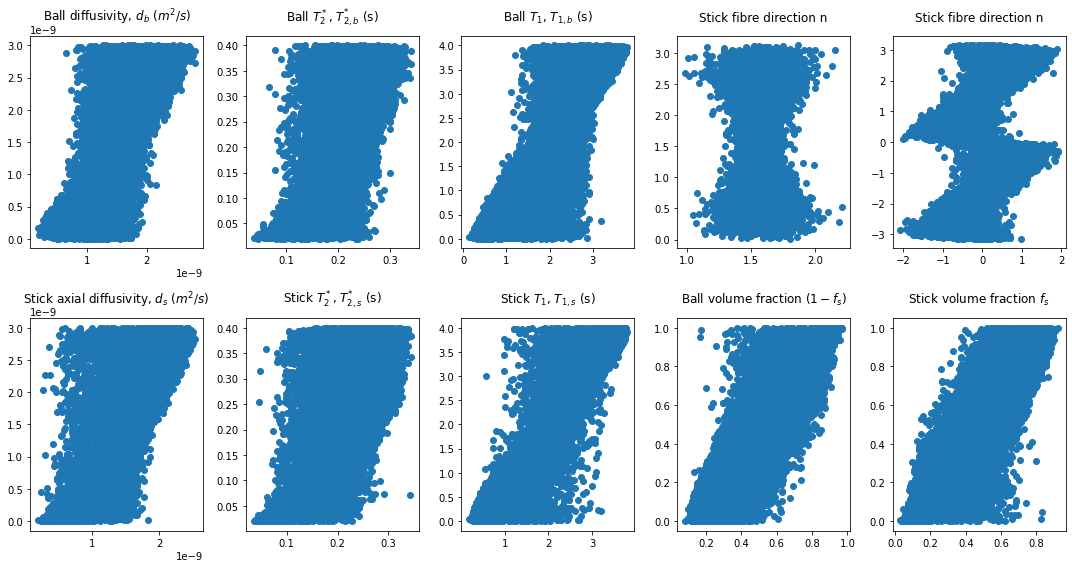

In [25]:
"""Generate scatter plots for each parameter (normal data)"""

import matplotlib.pyplot as plt

fig, ((ax1, ax2, ax3, ax4, ax5),(ax6, ax7, ax8, ax9, ax10)) = plt.subplots(nrows=2, ncols=5, figsize=(15,8))

# Should get 20000 data points
ax1.scatter(y_rf[:,0],y_test[:,0])
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$", pad=15) # G1BallRelaxed_1_lambda_iso

ax2.scatter(y_rf[:,1],y_test[:,1])
ax2.set_title("Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)", pad=15) # G1BallRelaxed_1_t2

ax3.scatter(y_rf[:,2],y_test[:,2])
ax3.set_title("Ball $T_{1}$, $T_{1,b}$ (s)", pad=15) # G1BallRelaxed_1_t1

ax4.scatter(y_rf[:,3],y_test[:,3])
ax4.set_title("Stick fibre direction n", pad=15) # C1StickRelaxed_1_mu

ax5.scatter(y_rf[:,4],y_test[:,4])
ax5.set_title("Stick fibre direction n", pad=15) # C1StickRelaxed_1_mu

ax6.scatter(y_rf[:,5],y_test[:,5])
ax6.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$", pad=15) # C1StickRelaxed_1_lambda_par

ax7.scatter(y_rf[:,6],y_test[:,6])
ax7.set_title("Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)", pad=15) # C1StickRelaxed_1_t2

ax8.scatter(y_rf[:,7],y_test[:,7])
ax8.set_title("Stick $T_{1}$, $T_{1,s}$ (s)", pad=15) # C1StickRelaxed_1_t1

ax9.scatter(y_rf[:,8],y_test[:,8])
ax9.set_title("Ball volume fraction $(1 - f_s)$", pad=15) # partial_volume_0

ax10.scatter(y_rf[:,9],y_test[:,9])
ax10.set_title("Stick volume fraction $f_s$", pad=15) # partial_volume_1

fig.tight_layout()

plt.savefig("figure7.png", dpi=600) # Save figure as png

In [26]:
"""Calculate r2_scores for each parameter (normal data)"""

# Import relevant modules
from sklearn.metrics import r2_score
import pandas as pd

# Calculate r2_scores
r2 = [r2_score(y_test[:,i], y_rf[:,i]) for i in range(0,10)]

# Create index of parameters
ind = ['Ball diffusivity, $d_b$ $(m^2/s)$','Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)','Ball $T_{1}$, $T_{1,b}$ (s)',
       'Stick fibre direction n', 'Stick fibre direction n','Stick axial diffusivity, $d_s$ $(m^2/s)$',
       'Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)','Stick $T_{1}$, $T_{1,s}$ (s)',
       'Ball volume fraction $(1 - f_s)$','Stick volume fraction $f_s$']

# Create DataFrame table to show the scores
r2_table = pd.DataFrame(r2, index=ind, columns=['$R^2$ Score'])
r2_table

,$R^2$ Score
"Ball diffusivity, $d_b$ $(m^2/s)$",0.493010
"Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)",0.321663
"Ball $T_{1}$, $T_{1,b}$ (s)",0.651817
Stick fibre direction n,-0.023793
Stick fibre direction n,0.148858
"Stick axial diffusivity, $d_s$ $(m^2/s)$",0.572412
"Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)",0.441602
"Stick $T_{1}$, $T_{1,s}$ (s)",0.850107
Ball volume fraction $(1 - f_s)$,0.702904
Stick volume fraction $f_s$,0.702904


In [ ]:
"""Modify the synthetic dataset with added Rician distributed noise"""

ml_dataset_noisy = ml_dataset + 1/((100-20)*np.random.rand(ml_dataset.shape[0], ml_dataset.shape[1])+20)*np.random.randn(ml_dataset.shape[0], ml_dataset.shape[1])

In [ ]:
# Check the shape of modified dataset
ml_dataset_noisy.shape # Should be 10^5 by 1344

In [ ]:
"""Split data into training (80%) & testing (20%) for the dataset with noise"""

X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(ml_dataset_noisy, param_dataset, 
                                                                            test_size=0.2, random_state=42)

In [ ]:
"""Initiate scikit-learn's Random Forest regressor with 200 decision trees of depth 20"""

from sklearn.ensemble import RandomForestRegressor
regressor_noisy = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=20, max_features="sqrt", n_jobs=4)

In [30]:
# Fit the random forest regressor to the training data with noise and calculate time taken
start_time = time.time()
regressor_noisy.fit(X_train_noisy, y_train_noisy)
print("RF noisy training time: %s seconds" % (time.time() - start_time))

RF noisy training time: 683.4316627979279 seconds


In [31]:
# Use the random forest regressor to predict the test data with noise and calculate time taken
start_time = time.time()
y_rf_noisy = regressor_noisy.predict(X_test_noisy)
print("RF noisy prediction time: %s seconds" % (time.time() - start_time))

RF noisy prediction time: 19.450501918792725 seconds


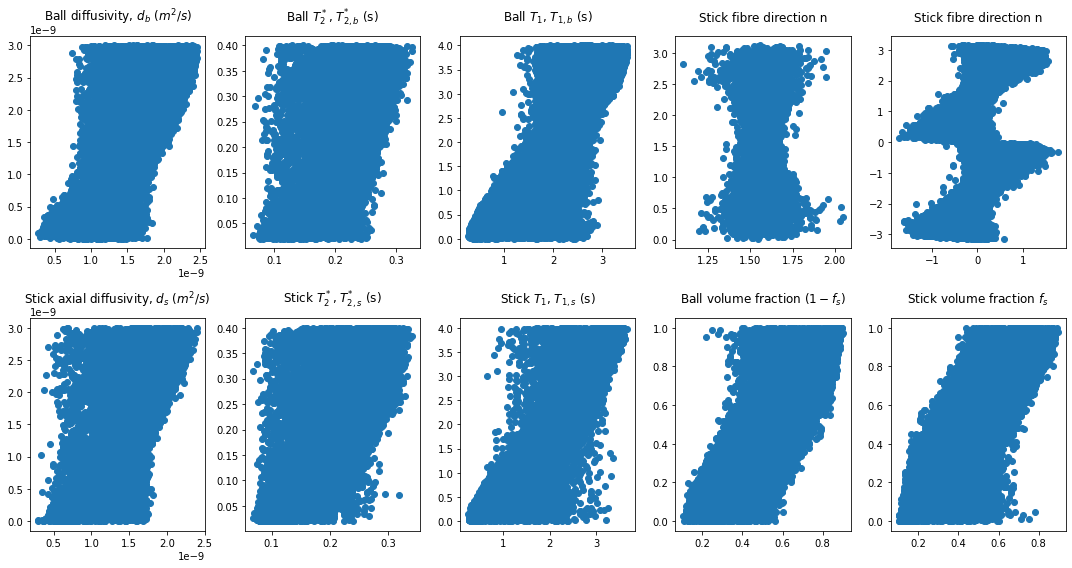

In [32]:
"""Generate scatter plots for each parameter (noisy data)"""

fig, ((ax1, ax2, ax3, ax4, ax5),(ax6, ax7, ax8, ax9, ax10)) = plt.subplots(nrows=2, ncols=5, figsize=(15,8))

# Should get 20000 data points
ax1.scatter(y_rf_noisy[:,0],y_test_noisy[:,0])
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$", pad=15) # G1BallRelaxed_1_lambda_iso

ax2.scatter(y_rf_noisy[:,1],y_test_noisy[:,1])
ax2.set_title("Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)", pad=15) # G1BallRelaxed_1_t2

ax3.scatter(y_rf_noisy[:,2],y_test_noisy[:,2])
ax3.set_title("Ball $T_{1}$, $T_{1,b}$ (s)", pad=15) # G1BallRelaxed_1_t1

ax4.scatter(y_rf_noisy[:,3],y_test_noisy[:,3])
ax4.set_title("Stick fibre direction n", pad=15) # C1StickRelaxed_1_mu

ax5.scatter(y_rf_noisy[:,4],y_test_noisy[:,4])
ax5.set_title("Stick fibre direction n", pad=15) # C1StickRelaxed_1_mu

ax6.scatter(y_rf_noisy[:,5],y_test_noisy[:,5])
ax6.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$", pad=15) # C1StickRelaxed_1_lambda_par

ax7.scatter(y_rf_noisy[:,6],y_test_noisy[:,6])
ax7.set_title("Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)", pad=15) # C1StickRelaxed_1_t2

ax8.scatter(y_rf_noisy[:,7],y_test_noisy[:,7])
ax8.set_title("Stick $T_{1}$, $T_{1,s}$ (s)", pad=15) # C1StickRelaxed_1_t1

ax9.scatter(y_rf_noisy[:,8],y_test_noisy[:,8])
ax9.set_title("Ball volume fraction $(1 - f_s)$", pad=15) # partial_volume_0

ax10.scatter(y_rf_noisy[:,9],y_test_noisy[:,9])
ax10.set_title("Stick volume fraction $f_s$", pad=15) # partial_volume_1

fig.tight_layout()

plt.savefig("figure9.png", dpi=600) # Save figure as png

In [31]:
"""Calculate r2_scores for each parameter (noisy data)"""

# Import relevant modules
from sklearn.metrics import r2_score
import pandas as pd

# Calculate r2_scores
r2 = [r2_score(y_test_noisy[:,i], y_rf_noisy[:,i]) for i in range(0,10)]

# Create index of parameters
ind = ['Ball diffusivity, $d_b$ $(m^2/s)$','Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)','Ball $T_{1}$, $T_{1,b}$ (s)',
       'Stick fibre direction n', 'Stick fibre direction n','Stick axial diffusivity, $d_s$ $(m^2/s)$',
       'Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)','Stick $T_{1}$, $T_{1,s}$ (s)',
       'Ball volume fraction $(1 - f_s)$','Stick volume fraction $f_s$']

# Create DataFrame table to show the scores
r2_table = pd.DataFrame(r2, index=ind, columns=['$R^2$ Score'])
r2_table

,$R^2$ Score
"Ball diffusivity, $d_b$ $(m^2/s)$",0.384841
"Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)",0.291892
"Ball $T_{1}$, $T_{1,b}$ (s)",0.578472
Stick fibre direction n,-0.008971
Stick fibre direction n,0.128953
"Stick axial diffusivity, $d_s$ $(m^2/s)$",0.407249
"Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)",0.373704
"Stick $T_{1}$, $T_{1,s}$ (s)",0.721323
Ball volume fraction $(1 - f_s)$,0.627665
Stick volume fraction $f_s$,0.627665


In [ ]:
# Reshape the combined diffusion-relaxometry data
import numpy as np
reshaped_data = np.reshape(data, (77*92*56, 1344)) 
reshaped_data.shape # should be 396704 x 1344

In [ ]:
# From acquisition scheme, find index where max TE, min TI and bvalue=0
np.where((TI>=6) & (TE==0.08) & (bvalues==0)) # should be 55

In [22]:
# Take out 55th column, this is where max TE, min TI, bvalue=0
reshaped_data[...,55].shape # 396704 rows

(396704,)

In [23]:
print(reshaped_data.shape)
# np.tile - repeat 55th column 1344 times & then transpose so it's the same shape as reshaped_data
transposed = np.transpose(np.tile(reshaped_data[...,55], (1344, 1)))  
transposed.shape

(396704, 1344)


(396704, 1344)

In [24]:
# Normalise the rehaped data
y = reshaped_data/transposed # Get warning because dividing by zero in some cases but can ignore this
print(y)

<ipython-input-24-aa126e1fb1e0>:1: RuntimeWarning: invalid value encountered in true_divide
  y = reshaped_data/transposed # error because dividing by zero in some cases but can ignore this


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [25]:
# Replace all nans and infs with zero
mask_nan = np.any(np.isnan(y), axis=1)
mask_inf = np.any(np.isinf(y), axis=1)
y[mask_nan] = 0
y[mask_inf] = 0
y.shape

(396704, 1344)

In [26]:
"""Use random forest regressor to predict whole MRI data and calculate time taken"""

start_time = time.time()
y_pred = regressor.predict(y)
print("RF normal whole data prediction time: %s seconds" % (time.time() - start_time))
y_pred.shape

RF normal whole data prediction time: 24.84264612197876 seconds


(396704, 10)

In [27]:
# Reshape the whole data prediction back to 4 dimensions
param_map = np.reshape(y_pred, (77,92,56,10))
param_map.shape

(77, 92, 56, 10)

In [ ]:
# Save predicted array as numpy array file
# np.save("rf_relaxed_bas_normal", param_map)

In [2]:
# Load the predicted array file
import numpy as np
param_map = np.load("rf_relaxed_bas_normal.npy")

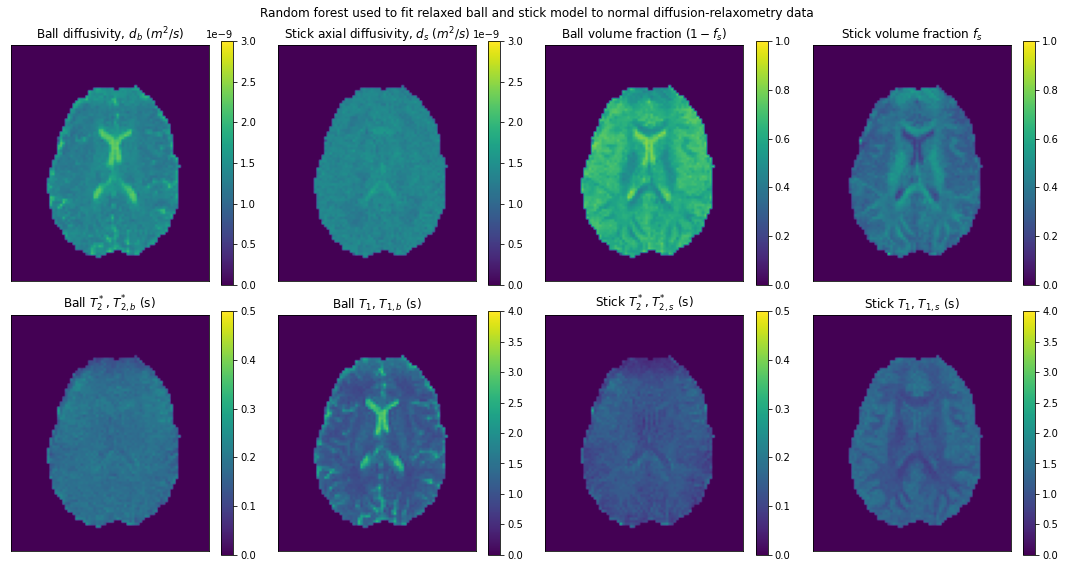

In [4]:
"""Create a set of microstructure maps with colorbars (normal data)"""

import matplotlib.pyplot as plt
import math

fig, ((ax1, ax6, ax9, ax10), (ax2, ax3, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

im1 = ax1.imshow(np.rot90(param_map[:,:,30,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$") # G1BallRelaxed_1_lambda_iso
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(im1, ax=ax1)

im6 = ax6.imshow(np.rot90(param_map[:,:,30,5]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax6.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$") # C1StickRelaxed_1_lambda_par
ax6.set_xticks([])
ax6.set_yticks([])
fig.colorbar(im6, ax=ax6)

im9 = ax9.imshow(np.rot90(param_map[:,:,30,8]*mask_data[:,:,30]), vmin=0, vmax=1)
ax9.set_title("Ball volume fraction $(1 - f_s)$") # partial_volume_0
ax9.set_xticks([])
ax9.set_yticks([])
fig.colorbar(im9, ax=ax9)

im10 = ax10.imshow(np.rot90(param_map[:,:,30,9]*mask_data[:,:,30]), vmin=0, vmax=1)
ax10.set_title("Stick volume fraction $f_s$") # partial_volume_1
ax10.set_xticks([])
ax10.set_yticks([])
fig.colorbar(im10, ax=ax10)

im2 = ax2.imshow(np.rot90(param_map[:,:,30,1]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax2.set_title("Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)") # G1BallRelaxed_1_t2
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(np.rot90(param_map[:,:,30,2]*mask_data[:,:,30]), vmin=0, vmax=4)
ax3.set_title("Ball $T_{1}$, $T_{1,b}$ (s)") # G1BallRelaxed_1_t1
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3)

im7 = ax7.imshow(np.rot90(param_map[:,:,30,6]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax7.set_title("Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)") # C1StickRelaxed_1_t2
ax7.set_xticks([])
ax7.set_yticks([])
fig.colorbar(im7, ax=ax7)

im8 = ax8.imshow(np.rot90(param_map[:,:,30,7]*mask_data[:,:,30]), vmin=0, vmax=4)
ax8.set_title("Stick $T_{1}$, $T_{1,s}$ (s)")  # C1StickRelaxed_1_t1
ax8.set_xticks([])
ax8.set_yticks([])
fig.colorbar(im8, ax=ax8)

fig.suptitle('Random forest used to fit relaxed ball and stick model to normal diffusion-relaxometry data')

fig.tight_layout()

plt.savefig("figure3.png", dpi=600) # Save figure as png

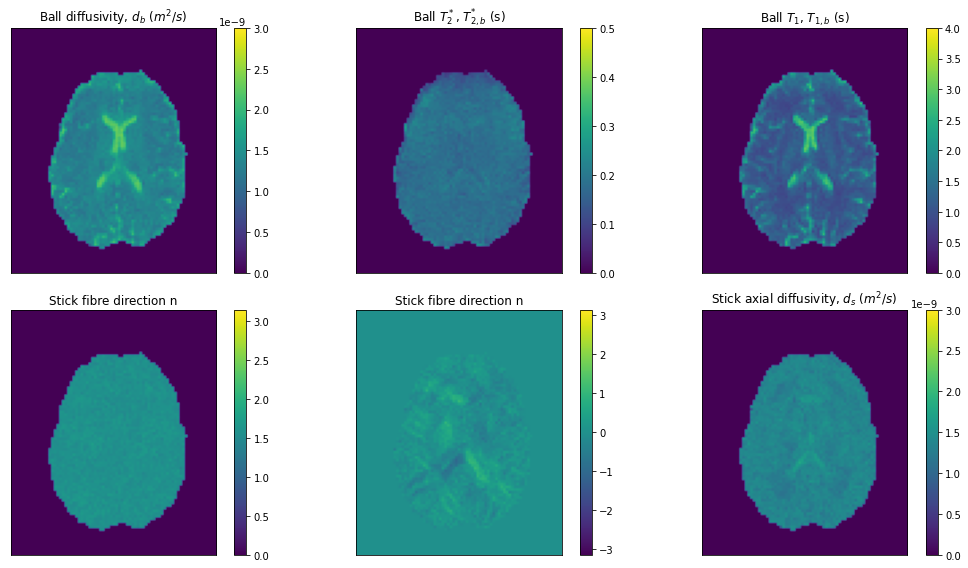

In [25]:
import matplotlib.pyplot as plt
import math

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

im1 = ax1.imshow(np.rot90(param_map[:,:,30,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$") # G1BallRelaxed_1_lambda_iso
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(np.rot90(param_map[:,:,30,1]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax2.set_title("Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)") # G1BallRelaxed_1_t2
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(np.rot90(param_map[:,:,30,2]*mask_data[:,:,30]), vmin=0, vmax=4)
ax3.set_title("Ball $T_{1}$, $T_{1,b}$ (s)") # G1BallRelaxed_1_t1
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3)

im4 = ax4.imshow(np.rot90(param_map[:,:,30,3]*mask_data[:,:,30]), vmin=0, vmax=math.pi)
ax4.set_title("Stick fibre direction n") # C1StickRelaxed_1_mu
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(im4, ax=ax4)

im5 = ax5.imshow(np.rot90(param_map[:,:,30,4]*mask_data[:,:,30]), vmin=-math.pi, vmax=math.pi)
ax5.set_title("Stick fibre direction n") # C1StickRelaxed_1_mu
ax5.set_xticks([])
ax5.set_yticks([])
fig.colorbar(im5, ax=ax5)

im6 = ax6.imshow(np.rot90(param_map[:,:,30,5]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax6.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$") # C1StickRelaxed_1_lambda_par
ax6.set_xticks([])
ax6.set_yticks([])
fig.colorbar(im6, ax=ax6)

fig.tight_layout()

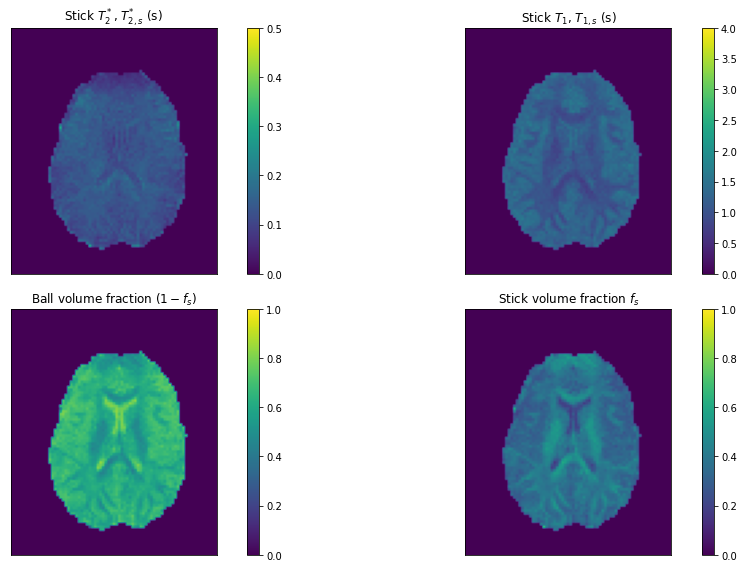

In [26]:
fig, ((ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

im7 = ax7.imshow(np.rot90(param_map[:,:,30,6]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax7.set_title("Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)") # C1StickRelaxed_1_t2
ax7.set_xticks([])
ax7.set_yticks([])
fig.colorbar(im7, ax=ax7)

im8 = ax8.imshow(np.rot90(param_map[:,:,30,7]*mask_data[:,:,30]), vmin=0, vmax=4)
ax8.set_title("Stick $T_{1}$, $T_{1,s}$ (s)")  # C1StickRelaxed_1_t1
ax8.set_xticks([])
ax8.set_yticks([])
fig.colorbar(im8, ax=ax8)

im9 = ax9.imshow(np.rot90(param_map[:,:,30,8]*mask_data[:,:,30]), vmin=0, vmax=1)
ax9.set_title("Ball volume fraction $(1 - f_s)$") # partial_volume_0
ax9.set_xticks([])
ax9.set_yticks([])
fig.colorbar(im9, ax=ax9)

im10 = ax10.imshow(np.rot90(param_map[:,:,30,9]*mask_data[:,:,30]), vmin=0, vmax=1)
ax10.set_title("Stick volume fraction $f_s$") # partial_volume_1
ax10.set_xticks([])
ax10.set_yticks([])
fig.colorbar(im10, ax=ax10)

fig.tight_layout()

In [30]:
"""Use random forest regressor to predict whole MRI data with noise and calculate time taken"""

start_time = time.time()
y_pred_noisy = regressor_noisy.predict(y)
print("RF noisy whole data prediction time: %s seconds" % (time.time() - start_time))
y_pred_noisy.shape

RF noisy whole data prediction time: 27.23989987373352 seconds


(396704, 10)

In [31]:
# Reshape the whole data prediction back to 4 dimensions
param_map_noisy = np.reshape(y_pred_noisy, (77,92,56,10))
param_map_noisy.shape

(77, 92, 56, 10)

In [41]:
# Save predicted array as numpy array file
# np.save("rf_relaxed_bas_noisy", param_map_noisy)

In [5]:
# Load the predicted array
import numpy as np
param_map_noisy = np.load("rf_relaxed_bas_noisy.npy")

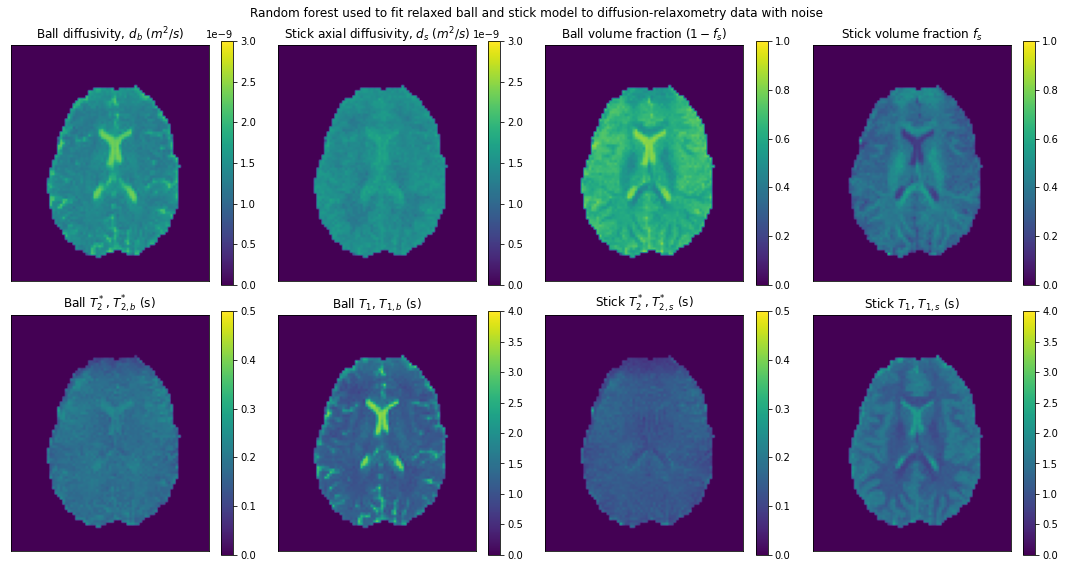

In [7]:
"""Create a set of parameter maps with colorbars (noisy data)"""

import matplotlib.pyplot as plt
import math

fig, ((ax1, ax6, ax9, ax10), (ax2, ax3, ax7, ax8)) = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

im1 = ax1.imshow(np.rot90(param_map_noisy[:,:,30,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$") # G1BallRelaxed_1_lambda_iso
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(im1, ax=ax1)

im6 = ax6.imshow(np.rot90(param_map_noisy[:,:,30,5]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax6.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$") # C1StickRelaxed_1_lambda_par
ax6.set_xticks([])
ax6.set_yticks([])
fig.colorbar(im6, ax=ax6)

im9 = ax9.imshow(np.rot90(param_map_noisy[:,:,30,8]*mask_data[:,:,30]), vmin=0, vmax=1)
ax9.set_title("Ball volume fraction $(1 - f_s)$") # partial_volume_0
ax9.set_xticks([])
ax9.set_yticks([])
fig.colorbar(im9, ax=ax9)

im10 = ax10.imshow(np.rot90(param_map_noisy[:,:,30,9]*mask_data[:,:,30]), vmin=0, vmax=1)
ax10.set_title("Stick volume fraction $f_s$") # partial_volume_1
ax10.set_xticks([])
ax10.set_yticks([])
fig.colorbar(im10, ax=ax10)

im2 = ax2.imshow(np.rot90(param_map_noisy[:,:,30,1]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax2.set_title("Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)") # G1BallRelaxed_1_t2
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(np.rot90(param_map_noisy[:,:,30,2]*mask_data[:,:,30]), vmin=0, vmax=4)
ax3.set_title("Ball $T_{1}$, $T_{1,b}$ (s)") # G1BallRelaxed_1_t1
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3)

im7 = ax7.imshow(np.rot90(param_map_noisy[:,:,30,6]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax7.set_title("Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)") # C1StickRelaxed_1_t2
ax7.set_xticks([])
ax7.set_yticks([])
fig.colorbar(im7, ax=ax7)

im8 = ax8.imshow(np.rot90(param_map_noisy[:,:,30,7]*mask_data[:,:,30]), vmin=0, vmax=4)
ax8.set_title("Stick $T_{1}$, $T_{1,s}$ (s)")  # C1StickRelaxed_1_t1
ax8.set_xticks([])
ax8.set_yticks([])
fig.colorbar(im8, ax=ax8)

fig.suptitle('Random forest used to fit relaxed ball and stick model to diffusion-relaxometry data with noise')

fig.tight_layout()

plt.savefig("figure4.png", dpi=600) # Save figure as png

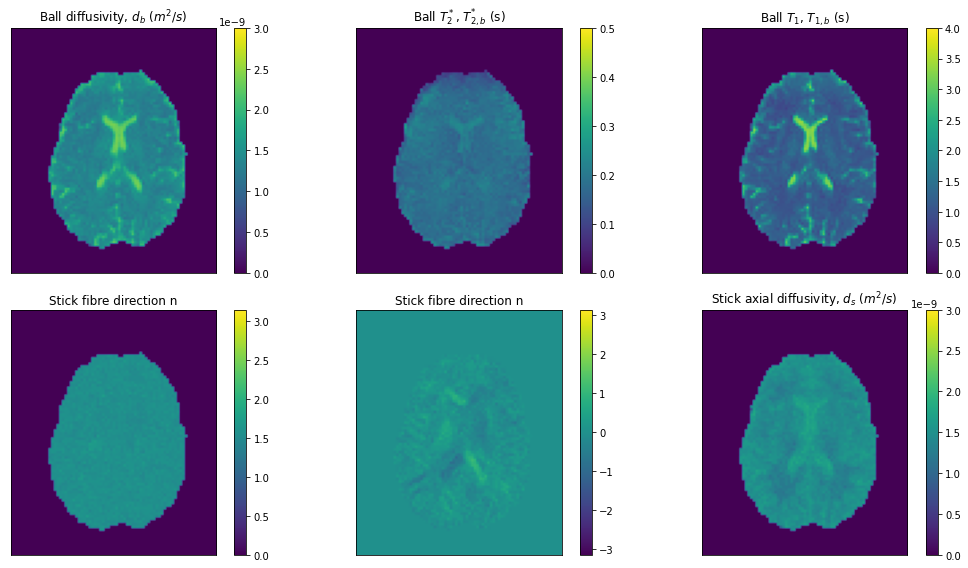

In [28]:
import matplotlib.pyplot as plt
import math

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

im1 = ax1.imshow(np.rot90(param_map_noisy[:,:,30,0]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax1.set_title("Ball diffusivity, $d_b$ $(m^2/s)$") # G1BallRelaxed_1_lambda_iso
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(np.rot90(param_map_noisy[:,:,30,1]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax2.set_title("Ball $T_{2}^*$, $T_{2,b}^{*}$ (s)") # G1BallRelaxed_1_t2
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(np.rot90(param_map_noisy[:,:,30,2]*mask_data[:,:,30]), vmin=0, vmax=4)
ax3.set_title("Ball $T_{1}$, $T_{1,b}$ (s)") # G1BallRelaxed_1_t1
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(im3, ax=ax3)

im4 = ax4.imshow(np.rot90(param_map_noisy[:,:,30,3]*mask_data[:,:,30]), vmin=0, vmax=math.pi)
ax4.set_title("Stick fibre direction n") # C1StickRelaxed_1_mu
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(im4, ax=ax4)

im5 = ax5.imshow(np.rot90(param_map_noisy[:,:,30,4]*mask_data[:,:,30]), vmin=-math.pi, vmax=math.pi)
ax5.set_title("Stick fibre direction n") # C1StickRelaxed_1_mu
ax5.set_xticks([])
ax5.set_yticks([])
fig.colorbar(im5, ax=ax5)

im6 = ax6.imshow(np.rot90(param_map_noisy[:,:,30,5]*mask_data[:,:,30]), vmin=0, vmax=3e-9)
ax6.set_title("Stick axial diffusivity, $d_s$ $(m^2/s)$") # C1StickRelaxed_1_lambda_par
ax6.set_xticks([])
ax6.set_yticks([])
fig.colorbar(im6, ax=ax6)

fig.tight_layout()

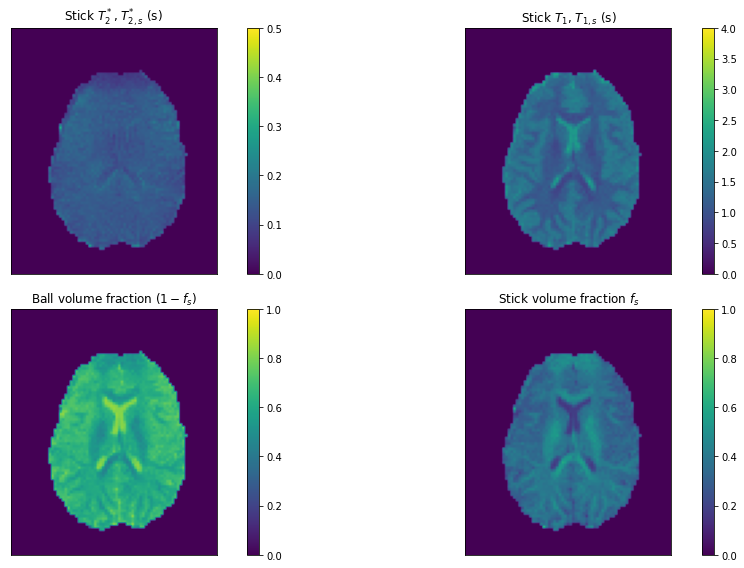

In [29]:
fig, ((ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

im7 = ax7.imshow(np.rot90(param_map_noisy[:,:,30,6]*mask_data[:,:,30]), vmin=0, vmax=0.5)
ax7.set_title("Stick $T_{2}^*$, $T_{2,s}^{*}$ (s)") # C1StickRelaxed_1_t2
ax7.set_xticks([])
ax7.set_yticks([])
fig.colorbar(im7, ax=ax7)

im8 = ax8.imshow(np.rot90(param_map_noisy[:,:,30,7]*mask_data[:,:,30]), vmin=0, vmax=4)
ax8.set_title("Stick $T_{1}$, $T_{1,s}$ (s)")  # C1StickRelaxed_1_t1
ax8.set_xticks([])
ax8.set_yticks([])
fig.colorbar(im8, ax=ax8)

im9 = ax9.imshow(np.rot90(param_map_noisy[:,:,30,8]*mask_data[:,:,30]), vmin=0, vmax=1)
ax9.set_title("Ball volume fraction $(1 - f_s)$") # partial_volume_0
ax9.set_xticks([])
ax9.set_yticks([])
fig.colorbar(im9, ax=ax9)

im10 = ax10.imshow(np.rot90(param_map_noisy[:,:,30,9]*mask_data[:,:,30]), vmin=0, vmax=1)
ax10.set_title("Stick volume fraction $f_s$") # partial_volume_1
ax10.set_xticks([])
ax10.set_yticks([])
fig.colorbar(im10, ax=ax10)

fig.tight_layout()